# Filtering out uptake and transfer from my doubling time analyses

In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from macrohet import visualise
from tqdm.auto import tqdm
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import r2_score

# Conversion factor
meters_per_pixel = 1.4949402023919043E-07  # Micrometers per pixel
micrometers_per_pixel = meters_per_pixel*1E6 # Micrometers per pixel

# set display params
sns.set(style = 'white')
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Nimbus Sans'
# import matplotlib as mpl
# mpl.rcdefaults()
# Get the color palette of the PiYG color map
colours = expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)
import tempfile
import napari
import glob
import imageio
import skimage.transform
import shutil

#### Function

In [2]:
def plot(ID, df, save = False, napari = False):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        # return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        # Start from the minimum and double
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        # non_doubling_curves.append(ID)
        print(f'No obvious growth for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        # Maximum occurs before the minimum (indicating a reduction)
        # Start from the maximum and halve
        N_i = max_value
        N_series = []
        
        # Generate the halving series
        while N_i >= min_value:
            N_series.append(N_i)
            N_i /= 2
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # if not growth:
    #     doubling_times = [-t for t in doubling_times]
    #     N_series = [-n for n in N_series]  
    
    # Incorporate N_series and doubling_times into the main DataFrame
    # Assign lists to all entries in df with the same ID
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    # df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
    # # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
        # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)
    
    if save:    
        plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v3/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
        # plt.close()
    if napari:
        # Save the current plot to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_plot:
            plt.savefig(tmp_plot.name, bbox_inches='tight', dpi=314)
            plot_image_path = tmp_plot.name
        plot_image = imageio.imread(plot_image_path)
        # Resize the plot image to have a width of 750 pixels, maintaining aspect ratio
        height, width = plot_image.shape[:2]
        new_width = 750
        scale_factor = new_width / width
        new_height = int(height * scale_factor)
        resized_plot_image = skimage.transform.resize(plot_image, (new_height, new_width), anti_aliasing=True)
        viewer.add_image(resized_plot_image, name=f'ID: {ID} Plot', )#colormap='gray')
        return doubling_times, N_series
    else:    
        plt.show()

## Load params and data

In [42]:
output_dir = '/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v4'#/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'#'/Users/dayn/data/macrohet_mac/temp_results/'#
os.makedirs(output_dir, exist_ok = True)

In [189]:
# dt_df= pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/arx/dt_df.pkl')
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/sc_df.pkl')
df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
0,1.3.12.ND0003,0.0,0.000000,0.000000,1400.533422,-557.437690,NaN,False,False,656.800842,...,False,False,NaN,NaN,NaN,NaN,None,None,None,1.0
1,1.3.12.ND0003,0.5,0.000000,0.000000,1314.022525,-557.437690,NaN,False,False,661.850525,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
2,1.3.12.ND0003,1.0,0.000000,0.000000,1107.522736,-557.437690,NaN,False,False,664.685547,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
3,1.3.12.ND0003,1.5,0.000000,0.000000,1481.837127,-557.437690,NaN,False,False,668.500366,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
4,1.3.12.ND0003,2.0,NaN,0.000000,NaN,-557.437690,False,False,False,671.554077,...,False,False,NaN,NaN,0.0,0.0,None,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312257,998.5.5.ND0003,48.0,0.000000,-0.111742,813.037051,-539.871799,NaN,False,False,868.403076,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312258,998.5.5.ND0003,48.5,0.000000,-0.111742,745.745831,-539.871799,NaN,False,False,868.194641,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312259,998.5.5.ND0003,49.0,0.000000,-0.111742,668.219016,-539.871799,NaN,False,False,872.108582,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312260,998.5.5.ND0003,49.5,0.000000,-0.111742,662.609552,-539.871799,NaN,False,False,871.521606,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78


In [190]:
df[~df['Doubling Times'].isna()].drop_duplicates('ID')

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
543,1.3.5.PS0000,0.0,46.797680,136.772588,660.776979,-68.386294,NaN,True,True,519.922607,...,False,False,NaN,NaN,NaN,NaN,None,"[50.6, 101.2]",[28.0],0.97
773,1.4.9.PS0000,0.0,1.743180,121.732073,484.671082,377.532570,NaN,False,True,675.107422,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]","[4.0, 1.0, 2.0, 4.0, 24.0]",0.97
1226,1.6.5.PS0000,0.0,0.000000,232.200521,973.700145,969.208104,NaN,False,True,575.485962,...,False,True,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44, 122.88]","[1.0, 0.0, 0.0, 1.0, 0.0, 8.0]",0.7
2218,10.4.6.PS0000,0.0,18.862102,86.466200,810.332887,-447.371514,NaN,True,True,1094.156616,...,False,True,NaN,NaN,NaN,NaN,None,"[20.8, 41.6, 83.2]","[25.0, 31.0]",0.96
2856,100.3.4.PS0000,13.0,10.727262,26.594670,1492.631434,61.726452,True,False,True,648.689331,...,False,False,-0.402272,10.727262,13.0,10.152952,None,"[10.2, 20.4]",[48.0],0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310161,99.6.7.ND0003,0.0,6.123479,-6.123479,678.476961,-378.739387,NaN,False,True,64.146103,...,False,False,NaN,NaN,NaN,NaN,None,"[2.4, 4.8]",[3.0],0.63
1310604,990.4.8.ND0003,6.5,0.000000,8.380673,358.514029,728.515167,NaN,False,True,654.107849,...,False,False,NaN,NaN,NaN,NaN,Junk,"[1.92, 3.84, 7.68]","[2.5, 14.0]",0.65
1310745,990.4.9.ND0003,6.5,9.051127,0.603408,2858.681179,-1573.711655,NaN,True,True,590.168213,...,False,False,NaN,NaN,NaN,NaN,None,"[3.4, 6.8]",[9.5],0.37
1311046,991.4.5.PS0000,4.0,2.346589,32.829891,1537.216616,-899.078630,NaN,True,True,1085.988037,...,False,False,NaN,NaN,NaN,NaN,None,"[2.1, 4.2, 8.4, 16.8]","[17.0, 15.0, 13.0]",0.96


# First, recalculate the doubling times based on new models

In [5]:
len(df['ID'].unique())

13404

### We are only really intested in the grouwth rates of Mtb in cells that either are infected or become infected 
i.e. Final Infection Status = True

In [6]:
infected_df = df[(df['Final Infection Status'] == True) # check all values are from finally infected cells
                & (df.groupby('ID')['mtb_origin'].transform(lambda x: x.isna().all())) # check all values of mtb_origin for an ID are unknown (meaning it is genuine intracellular growth)
                & ~(df.groupby('ID')['Edge Status'].transform('any'))] # check all values do not touch the edge of the fov

In [41]:
print(len(infected_df['ID'].unique()))
IDs = infected_df['ID'].unique()

3038


In [8]:
import logging
import traceback

# Set up logging configuration to save the log file in the local directory
logging.basicConfig(filename='./error_log.log', level=logging.ERROR, 
                    format='%(asctime)s %(levelname)s:%(message)s')

# Initialize dictionaries to store ill-fitting curves and non-doubling curves
ill_fitting_curves = {}
non_doubling_curves = []

### Iterative execution

In [99]:
# df.loc[df['ID'] == ID, 'mtb_origin'] = 'Junk' 
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')#'/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


In [44]:
for ID in tqdm(IDs):
    try:
        # Get single-cell trajectory in df format
        sc_df = df[df['ID'] == ID]
        # Drop NaN values specifically from the required columns
        sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
        # Ensure there is temporal order
        sc_df = sc_df.sort_values(by='Time Model (hours)')
        
        # Extract Strain, Compound, and Concentration for the title
        strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
        
        # Calculate the R2 value and skip plotting if R2 < 0.7
        r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
        df.loc[df['ID'] == ID, 'r2'] = r2
        if r2 < 0.7:
            ill_fitting_curves[ID] = r2
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            print(f'Nee fitting ({r2})')
            continue
        
        # Find the temporal order of the minimum and maximum
        min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
        max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
        
        # perform a check on the data
        if max_value <= min_value:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
        
        # Find the time indices of the minimum and maximum
        min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
        max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
        
        # Check if maximum occurs before minimum
        if max_index > min_index:
            growth = True
            # Minimum occurs before the maximum (indicating growth)
            # Start from the minimum and double
            N_i = min_value
            N_series = []
            
            # Generate the doubling series
            while N_i <= max_value:
                N_series.append(N_i)
                N_i *= 2
            
        else:
            growth = False
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            # Maximum occurs before the minimum (indicating a reduction)
            # Start from the maximum and halve
            # N_i = max_value
            # N_series = []
            
            # # Generate the halving series
            # while N_i >= min_value:
            #     N_series.append(N_i)
            #     N_i /= 2
        
        
        # Check if there are no valid doubling points
        if len(N_series) < 2:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            
        # Find the indices and corresponding times for each doubling point
        doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
        doubling_time_indices = [np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]
        doubling_time_points = sc_df['Time Model (hours)'].loc[doubling_time_indices]
        doubling_times = doubling_time_points.diff().dropna().values.tolist()
        
        if not growth:
            doubling_times = [-t for t in doubling_times]
            N_series = [-n for n in N_series]  
        
        # Incorporate N_series and doubling_times into the main DataFrame
        # Assign lists to all entries in df with the same ID
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
        df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(8, 6))
        plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
        plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
        
        # Annotate doubling times and draw faint lines
        for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
            time = abs(time)
            population = abs(population)
            color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
            # Draw faint vertical lines at doubling time points
            plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            
            # Place a text label indicating the doubling time
            if i > 0:  # Start labeling from the second point
                previous_time = doubling_time_points.iloc[i-1]
                
                # Midpoint between the two lines
                label_x_pos = time  # Correct the label position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
        
                # Calculate the gap between the lines and scale the font size
                gap = time - previous_time
                scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
                
                # Draw the horizontal doubling time label
                plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                         ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
                
                # Draw vertical arrow showing the change in N_series (doubling amount)
                deltaMtb = population - N_series[i-1]
                
                # Midpoint for the vertical delta annotation
                text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
                text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        
                # Midpoint between the two lines
                label_x_pos = time + 0.1  # Adjust x-position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population - (max_value * 0.01)
                
                # Place the vertical label using plt.text
                plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                         fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
        
        # Add labels, legend, and titles
        plt.xlabel('Time (Hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        # Main title
        plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                     weight='bold', fontsize=16)
        # Subtitle
        plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
        
        sns.despine(offset=10)
        plt.grid(False)
        
        plt.savefig(os.path.join(output_dir, f'{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf'), bbox_inches = 'tight', dpi = 314)
        plt.close()
    
    except Exception as e:
        # Log the exception with traceback
        logging.error(f"Error while processing ID {ID}: {e}")
        logging.error(traceback.format_exc())
        print(f"An error occurred while processing ID {ID}. Check error_log.log for details.")

  0%|          | 0/3038 [00:00<?, ?it/s]

Nee fitting (0.45)
Nee fitting (0.37)
Nee fitting (0.54)
No population doubling for ID 10.3.10.ND0002
Nee fitting (0.51)
Nee fitting (0.59)
No population doubling for ID 1005.3.7.PS0000
Nee fitting (0.68)
Nee fitting (0.46)
No population doubling for ID 101.5.11.ND0003
Nee fitting (0.46)
Nee fitting (0.48)
Nee fitting (0.28)
No population doubling for ID 1019.3.10.ND0002
Nee fitting (0.51)
No population doubling for ID 102.6.8.ND0002
No population doubling for ID 102.6.8.PS0000
Nee fitting (0.62)
Nee fitting (0.6)
Nee fitting (0.66)
Nee fitting (0.42)
Nee fitting (0.29)
Nee fitting (0.43)
Nee fitting (0.57)
Nee fitting (0.44)
Nee fitting (0.63)
Nee fitting (0.63)
Nee fitting (0.53)
Nee fitting (-0.26)
Nee fitting (0.69)
Nee fitting (0.48)
Nee fitting (0.11)
Nee fitting (0.15)
Nee fitting (0.55)
Nee fitting (0.68)
Nee fitting (0.51)
No population doubling for ID 104.4.3.ND0002
Nee fitting (-0.44)
No population doubling for ID 104.6.8.PS0000
No population doubling for ID 104.6.9.PS0000
N

### Check specific cells

In [9]:
ID = '192.3.7.PS0000'

In [10]:
df[df['ID'] == ID]

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
375093,192.3.7.PS0000,0.0,23.734067,30.706787,1863.213633,-765.837099,NaN,True,True,1000.815063,...,False,False,NaN,NaN,NaN,NaN,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375094,192.3.7.PS0000,1.0,20.113616,30.706787,1776.456903,-765.837099,NaN,True,True,1006.957520,...,False,False,-3.620451,NaN,NaN,NaN,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375095,192.3.7.PS0000,2.0,31.645422,30.706787,1689.119113,-765.837099,True,True,True,1014.695007,...,False,False,11.531806,NaN,2.0,38.900516,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375096,192.3.7.PS0000,3.0,43.132532,30.706787,1531.875334,-765.837099,True,True,True,1014.413635,...,False,False,11.487110,NaN,3.0,39.975233,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375097,192.3.7.PS0000,4.0,36.293902,30.706787,1520.321179,-765.837099,True,True,True,1015.168274,...,False,False,-6.838629,31.645422,4.0,41.007196,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375163,192.3.7.PS0000,70.0,68.118112,30.706787,995.042926,-765.837099,True,True,True,1045.136963,...,False,False,1.676135,63.424935,70.0,66.021328,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375164,192.3.7.PS0000,71.0,64.475313,30.706787,976.292566,-765.837099,True,True,True,1044.146240,...,False,False,-3.642799,64.475313,71.0,67.201800,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375165,192.3.7.PS0000,72.0,66.441978,30.706787,1027.157666,-765.837099,True,True,True,1049.712402,...,False,False,1.966665,66.441978,72.0,68.342917,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375166,192.3.7.PS0000,73.0,65.995009,30.706787,964.626669,-765.837099,NaN,True,True,1048.604980,...,False,False,-0.446969,66.441978,NaN,NaN,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83


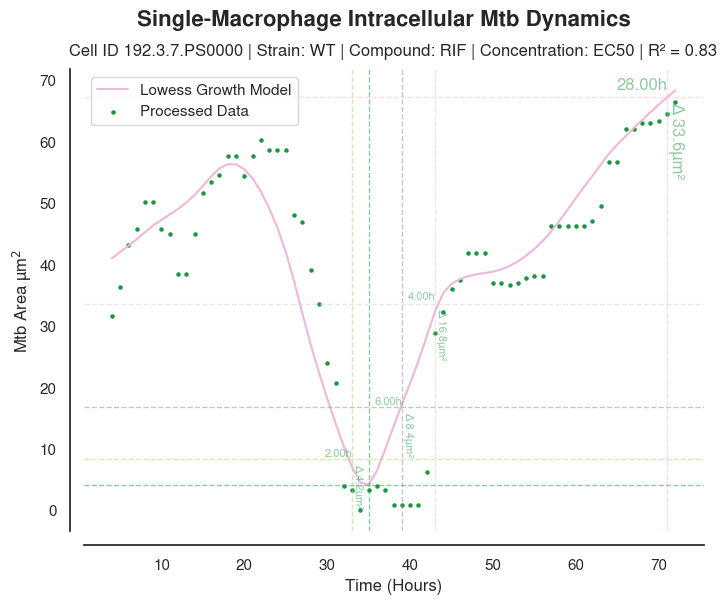

In [40]:
# Get single-cell trajectory in df format
sc_df = df[df['ID'] == ID]
# Drop NaN values specifically from the required columns
sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
# Ensure there is temporal order
sc_df = sc_df.sort_values(by='Time Model (hours)')
# Extract Strain, Compound, and Concentration for the title
strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
# Calculate the R2 value and skip plotting if R2 < 0.7
r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
df.loc[df['ID'] == ID, 'r2'] = r2
if r2 < 0.7:
    print(f'Nee fitting ({r2})')
# Find the temporal order of the minimum and maximum
min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
# perform a check on the data
if max_value <= min_value:
    print(f'No population doubling for ID {ID}')
# Find the time indices of the minimum and maximum
min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
# Check if maximum occurs before minimum
if max_index > min_index:
    growth = True
    # Minimum occurs before the maximum (indicating growth)
    # Start from the minimum and double
    N_i = min_value
    N_series = []
    # Generate the doubling series
    while N_i <= max_value:
        N_series.append(N_i)
        N_i *= 2
else:
    growth = False
    # non_doubling_curves.append(ID)
    print(f'No obvious growth for ID {ID}')
# Check if there are no valid doubling points
if len(N_series) < 2:
    print(f'No population doubling for ID {ID}')
    
# Find the indices and corresponding times for each doubling point
# doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1) # old method
doubling_time_indices = [np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]
doubling_time_points = sc_df['Time Model (hours)'].loc[closest_indices]
doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(8, 6))
plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)

# Annotate doubling times and draw faint lines
for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
    time = abs(time)
    population = abs(population)
    color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
    # Draw faint vertical lines at doubling time points
    plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    
    # Place a text label indicating the doubling time
    if i > 0:  # Start labeling from the second point
        previous_time = doubling_time_points.iloc[i-1]
        
        # Midpoint between the two lines
        label_x_pos = time  # Correct the label position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line

        # Calculate the gap between the lines and scale the font size
        gap = time - previous_time
        scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
        
        # Draw the horizontal doubling time label
        plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                 ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
        
        # Draw vertical arrow showing the change in N_series (doubling amount)
        deltaMtb = population - N_series[i-1]
        
        # Midpoint for the vertical delta annotation
        text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population

        # Midpoint between the two lines
        label_x_pos = time + 0.1  # Adjust x-position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population - (max_value * 0.01)
        
        # Place the vertical label using plt.text
        plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                 fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)

# Add labels, legend, and titles
plt.xlabel('Time (Hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
    # Main title
plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
             weight='bold', fontsize=16)
# Subtitle
plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)

sns.despine(offset=10)
plt.grid(False)

In [28]:
closest_indices

array([375128, 375126, 375132, 375136, 375164])

In [38]:
sc_df['Time Model (hours)'].iloc[[375128, 375126, 375132, 375136, 375164]]

IndexError: positional indexers are out-of-bounds

In [24]:
sc_df['Time Model (hours)']#.iloc[closest_indices]

375097     4.0
375098     5.0
375099     6.0
375100     7.0
375101     8.0
          ... 
375161    68.0
375162    69.0
375163    70.0
375164    71.0
375165    72.0
Name: Time Model (hours), Length: 69, dtype: float64

In [18]:
sc_df['Mtb Area Model (µm)'].values

array([41.00719601, 42.02285865, 43.05188927, 44.11986201, 45.23754087,
       46.36889731, 47.2600589 , 48.15904617, 49.04744801, 50.0639159 ,
       51.31843769, 52.80701554, 54.35388269, 55.64537292, 56.33669959,
       56.29473316, 55.49860789, 54.00798969, 51.86278045, 49.15989416,
       45.95393532, 42.04726826, 37.29682689, 32.05596852, 27.02447827,
       22.44646907, 18.20718853, 14.20556306, 10.4396191 ,  7.04400362,
        4.51282899,  4.1744207 ,  6.45487929,  9.9722285 , 13.64289892,
       17.204069  , 20.67600196, 24.27339804, 28.29299005, 32.40186966,
       35.34524744, 36.85245604, 37.62487131, 38.10956485, 38.41582245,
       38.61713726, 38.8418875 , 39.20586059, 39.76474504, 40.52375469,
       41.45277061, 42.54558321, 43.84164672, 45.36044294, 47.08329461,
       48.93497272, 50.81881311, 52.65872781, 54.45022327, 56.25487691,
       58.07232219, 59.52005168, 60.89060808, 62.23249283, 63.53706838,
       64.8001451 , 66.02132842, 67.20180048, 68.34291693])

In [20]:
np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series, side = 'left')

array([ 0,  0, 35, 40, 67])

In [15]:
N_series

[4.2, 8.4, 16.8, 33.6, 67.2]

In [14]:
doubling_time_indices

array([ 0,  0, 35, 40, 67])

In [13]:
doubling_times

[0.0, 35.0, 5.0, 27.0]

In [25]:
differences

375097    26.192804
375098    25.177141
375099    24.148111
375100    23.080138
375101    21.962459
            ...    
375161     3.662932
375162     2.399855
375163     1.178672
375164     0.001800
375165     1.142917
Name: Mtb Area Model (µm), Length: 69, dtype: float64

In [27]:
sc_df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
375097,192.3.7.PS0000,4.0,36.293902,30.706787,1520.321179,-765.837099,True,True,True,1015.168274,...,False,False,-6.838629,31.645422,4.0,41.007196,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375098,192.3.7.PS0000,5.0,51.759038,30.706787,2042.850571,-765.837099,True,True,True,1017.233337,...,False,False,15.465136,36.293902,5.0,42.022859,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375099,192.3.7.PS0000,6.0,45.859044,30.706787,1922.414709,-765.837099,True,True,True,1019.625366,...,False,False,-5.899994,43.132532,6.0,43.051889,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375100,192.3.7.PS0000,7.0,55.021914,30.706787,1878.030663,-765.837099,True,True,True,1019.817200,...,False,False,9.162869,45.859044,7.0,44.119862,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375101,192.3.7.PS0000,8.0,50.239343,30.706787,1723.245215,-765.837099,True,True,True,1018.286438,...,False,False,-4.782571,50.239343,8.0,45.237541,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375161,192.3.7.PS0000,68.0,63.424935,30.706787,1116.819696,-765.837099,True,True,True,1038.407593,...,False,False,10.749610,63.112057,68.0,63.537068,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375162,192.3.7.PS0000,69.0,66.441978,30.706787,1038.465988,-765.837099,True,True,True,1038.819824,...,False,False,3.017042,63.112057,69.0,64.800145,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375163,192.3.7.PS0000,70.0,68.118112,30.706787,995.042926,-765.837099,True,True,True,1045.136963,...,False,False,1.676135,63.424935,70.0,66.021328,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83
375164,192.3.7.PS0000,71.0,64.475313,30.706787,976.292566,-765.837099,True,True,True,1044.146240,...,False,False,-3.642799,64.475313,71.0,67.201800,None,"[4.2, 8.4, 16.8, 33.6, 67.2]","[0.0, 35.0, 5.0, 27.0]",0.83


In [26]:
closest_indices

array([375128, 375126, 375132, 375136, 375164])

In [21]:
# Find closest indices manually
closest_indices = []
for value in N_series:
    # Calculate the absolute differences
    differences = np.abs(sc_df['Mtb Area Model (µm)'] - value)
    
    # Find the index of the minimum difference
    closest_index = differences.idxmin()
    
    # Append to the list
    closest_indices.append(closest_index)

# Convert to an array
closest_indices= np.array(closest_indices)
closest_indices

array([375128, 375126, 375132, 375136, 375164])

In [39]:
[np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]

[375128, 375126, 375132, 375136, 375164]

In [22]:
df['Time (hours)'][closest_indices]

375128    35.0
375126    33.0
375132    39.0
375136    43.0
375164    71.0
Name: Time (hours), dtype: float64

329.6.4.PS0000


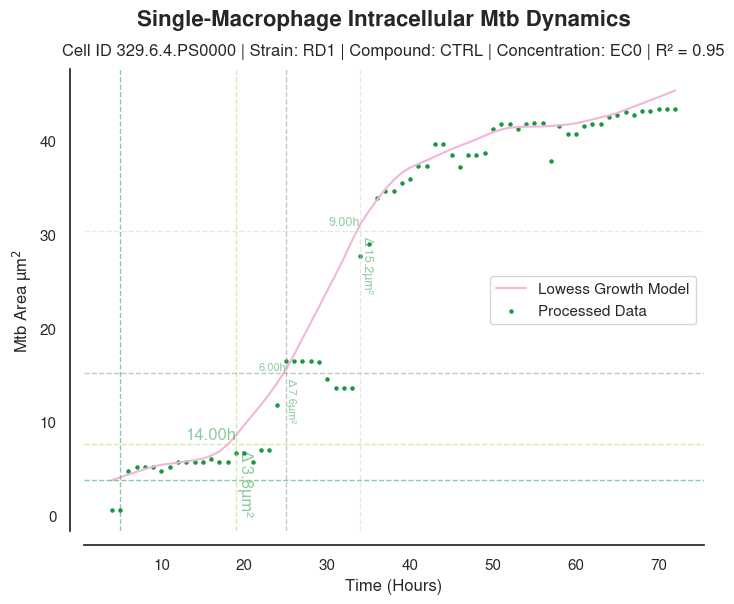

329.6.4.PS0000


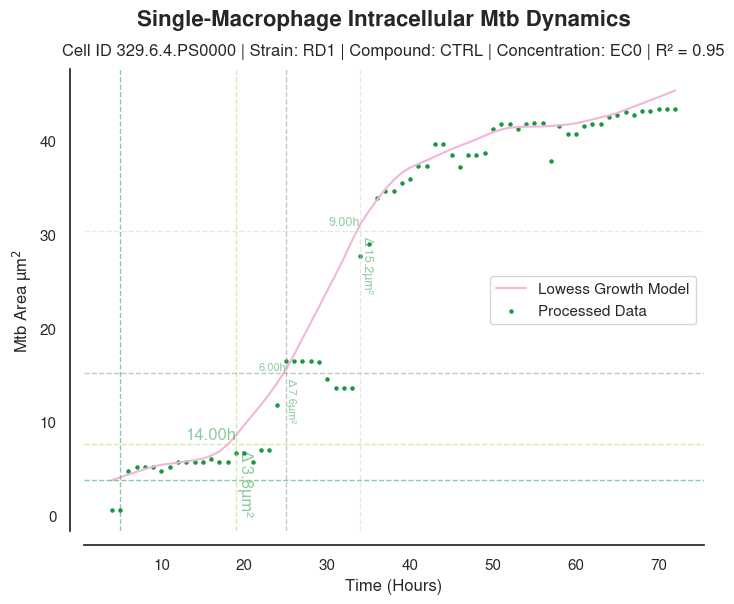

706.3.4.PS0000


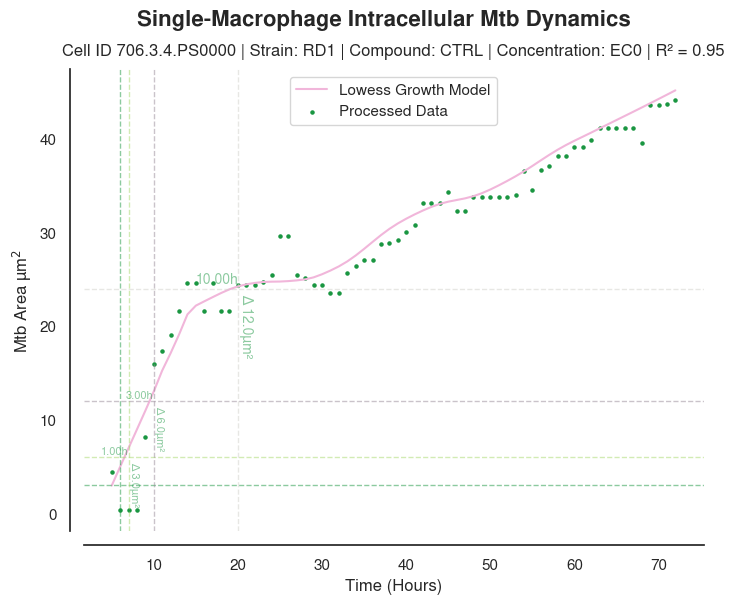

706.3.4.PS0000


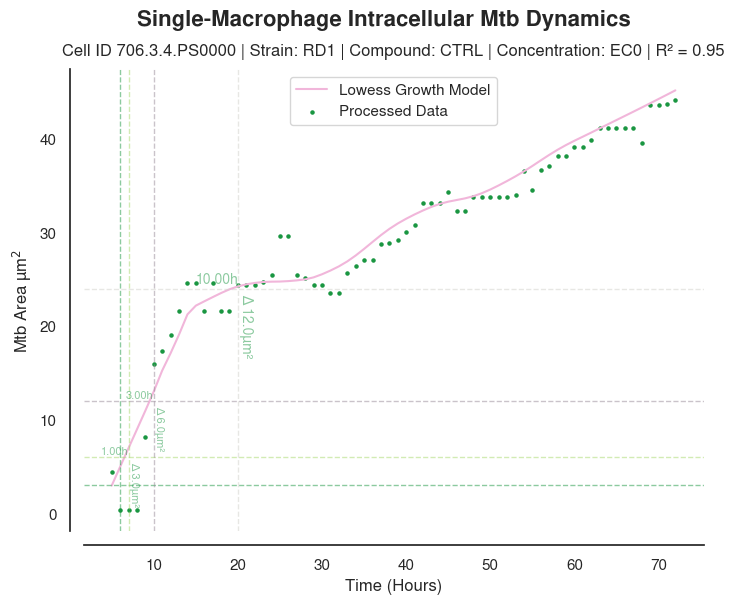

In [96]:
for i, ID in enumerate(subset_df[subset_df['Doubling Times'] < 10].ID.values):

    print(ID)    
    # if i <10:
    #     continue
    plot(ID, df, save = False, napari = False)

In [161]:
df.loc[df['ID'] == ID, 'mtb_origin'] = 'Transfer'
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


In [138]:
df.loc[df['ID'] == ID, 'mtb_origin'] = None
df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
df.loc[df['ID'] == ID, 'Doubling Times'] = None
# df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')#'/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


In [144]:
df.loc[df['ID'] == ID, 'mtb_origin'] = None
df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: [10.2], axis=1)
df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: [47], axis=1)
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


# Plot doubling times 

In [74]:
df['Strain'].unique()

array(['WT', 'UNI', 'RD1'], dtype=object)

<Axes: xlabel='Doubling Times', ylabel='Count'>

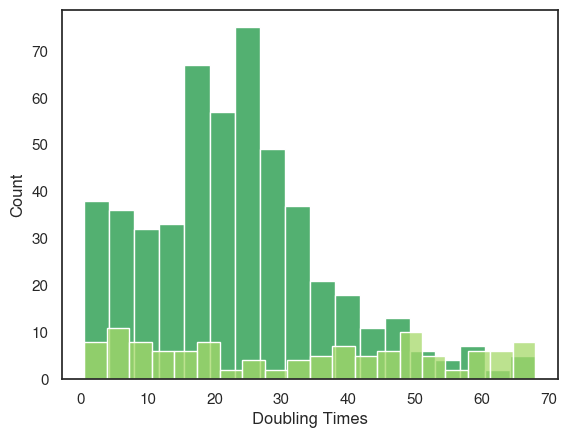

In [82]:
subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'WT') &
                (df['Concentration'] == 'EC0') 
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

sns.histplot(subset_df['Doubling Times'])

subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'RD1') &
                (df['Concentration'] == 'EC0') 
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

sns.histplot(subset_df['Doubling Times'], bins = 20)

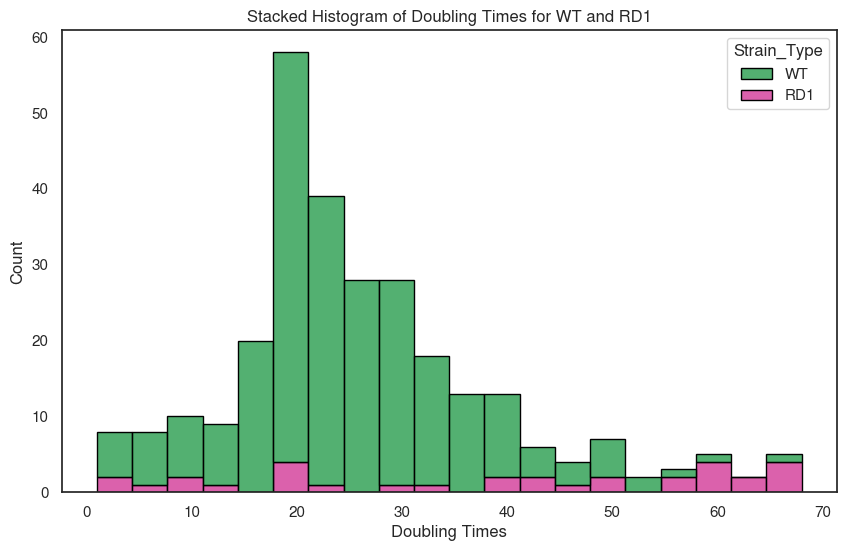

In [85]:
# Define colors for WT and RD1 from the 'expanded_piyg' palette
colors = [expanded_piyg[0], expanded_piyg[-1]]
r2_threshold = 0.95
# Combine the two subsets into one DataFrame with an additional 'Strain' column
subset_wt = df[(df['r2'] >= r2_threshold) & 
               (df['Edge Status'] == False) &
               (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'WT') &
               (df['Concentration'] == 'EC0')].drop_duplicates(subset=['ID'])

subset_rd1 = df[(df['r2'] >= r2_threshold) & 
                (df['Edge Status'] == False) &
                (df['mtb_origin'].isna()) & 
                (df['Strain'] == 'RD1') &
                (df['Concentration'] == 'EC0')].drop_duplicates(subset=['ID'])

# Add a 'Strain' column to each subset
subset_wt['Strain_Type'] = 'WT'
subset_rd1['Strain_Type'] = 'RD1'

# Combine the subsets
combined_df = pd.concat([subset_wt, subset_rd1])

# Explode the 'Doubling Times' column
combined_df = combined_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric and filter out NaN and non-positive values
combined_df['Doubling Times'] = pd.to_numeric(combined_df['Doubling Times'], errors='coerce')
combined_df = combined_df[combined_df['Doubling Times'].notna() & (combined_df['Doubling Times'] > 0)]

# Plot the stacked histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='Doubling Times', hue='Strain_Type', bins=20,
             palette=colors, multiple='stack', edgecolor='black')

# Add labels and title
plt.xlabel('Doubling Times')
plt.ylabel('Count')
plt.title('Stacked Histogram of Doubling Times for WT and RD1')

# Show plot
plt.show()


In [90]:
combined_df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2,Strain_Type
543,1.3.5.PS0000,0.0,46.797680,136.772588,660.776979,-68.386294,NaN,True,True,519.922607,...,False,NaN,NaN,NaN,NaN,None,"[50.6, 101.2]",28.0,0.97,WT
10615,1011.3.4.ND0002,11.0,34.036708,140.325993,479.262769,952.290318,NaN,True,True,682.521484,...,False,NaN,NaN,NaN,NaN,None,"[44.1, 88.2]",32.0,0.95,WT
25832,105.3.3.ND0003,0.0,51.736691,109.038147,500.292664,-184.799433,NaN,True,True,140.723206,...,False,NaN,NaN,NaN,NaN,None,"[65.7, 131.4]",38.5,0.97,WT
27216,105.6.5.PS0000,0.0,6.056433,30.393908,945.563416,518.774850,NaN,True,True,561.430908,...,False,NaN,NaN,NaN,NaN,None,"[6.5, 13.0, 26.0]",33.0,0.97,WT
27216,105.6.5.PS0000,0.0,6.056433,30.393908,945.563416,518.774850,NaN,True,True,561.430908,...,False,NaN,NaN,NaN,NaN,None,"[6.5, 13.0, 26.0]",25.0,0.97,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111261,637.4.4.PS0000,0.0,2.279543,14.325364,660.776979,658.944405,NaN,True,True,438.140167,...,False,NaN,NaN,NaN,NaN,None,"[4.0, 8.0]",20.0,0.95,RD1
1157488,706.3.4.PS0000,1.0,5.497722,40.048444,490.906318,1043.203862,NaN,False,True,378.841614,...,True,NaN,NaN,NaN,NaN,None,"[3.0, 6.0, 12.0, 24.0]",2.0,0.95,RD1
1157488,706.3.4.PS0000,1.0,5.497722,40.048444,490.906318,1043.203862,NaN,False,True,378.841614,...,True,NaN,NaN,NaN,NaN,None,"[3.0, 6.0, 12.0, 24.0]",2.0,0.95,RD1
1157488,706.3.4.PS0000,1.0,5.497722,40.048444,490.906318,1043.203862,NaN,False,True,378.841614,...,True,NaN,NaN,NaN,NaN,None,"[3.0, 6.0, 12.0, 24.0]",10.0,0.95,RD1


In [106]:
subset_df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
543,1.3.5.PS0000,0.0,46.797680,136.772588,660.776979,-68.386294,NaN,True,True,519.922607,...,False,False,NaN,NaN,NaN,NaN,None,"[50.6, 101.2]",28.0,0.97
10615,1011.3.4.ND0002,11.0,34.036708,140.325993,479.262769,952.290318,NaN,True,True,682.521484,...,False,False,NaN,NaN,NaN,NaN,None,"[44.1, 88.2]",32.0,0.95
22367,104.4.5.PS0000,0.0,9.810975,23.443537,769.569275,-185.492235,NaN,True,True,474.159943,...,False,False,NaN,NaN,NaN,NaN,None,"[8.5, 17.0, 34.0]",4.0,0.91
22367,104.4.5.PS0000,0.0,9.810975,23.443537,769.569275,-185.492235,NaN,True,True,474.159943,...,False,False,NaN,NaN,NaN,NaN,None,"[8.5, 17.0, 34.0]",10.0,0.91
25832,105.3.3.ND0003,0.0,51.736691,109.038147,500.292664,-184.799433,NaN,True,True,140.723206,...,False,False,NaN,NaN,NaN,NaN,None,"[65.7, 131.4]",38.5,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302763,974.4.5.PS0000,3.0,2.815906,93.327178,1808.862173,-1122.719690,NaN,False,True,840.663757,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[2.8, 5.6, 11.2, 22.4, 44.8]",6.0,0.94
1302763,974.4.5.PS0000,3.0,2.815906,93.327178,1808.862173,-1122.719690,NaN,False,True,840.663757,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[2.8, 5.6, 11.2, 22.4, 44.8]",29.0,0.94
1311046,991.4.5.PS0000,4.0,2.346589,32.829891,1537.216616,-899.078630,NaN,True,True,1085.988037,...,False,False,NaN,NaN,NaN,NaN,None,"[2.1, 4.2, 8.4, 16.8]",17.0,0.96
1311046,991.4.5.PS0000,4.0,2.346589,32.829891,1537.216616,-899.078630,NaN,True,True,1085.988037,...,False,False,NaN,NaN,NaN,NaN,None,"[2.1, 4.2, 8.4, 16.8]",15.0,0.96


In [109]:
(df['r2']>=0.8) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                # (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'UNI') & 
                (df['Compound'] == 'CTRL') (df['r2']>=0.8)

SyntaxError: invalid syntax (3520624012.py, line 1)

/tmp/ipykernel_2154516/2987388616.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.boxplot(x="Doubling Times", y="Strain",


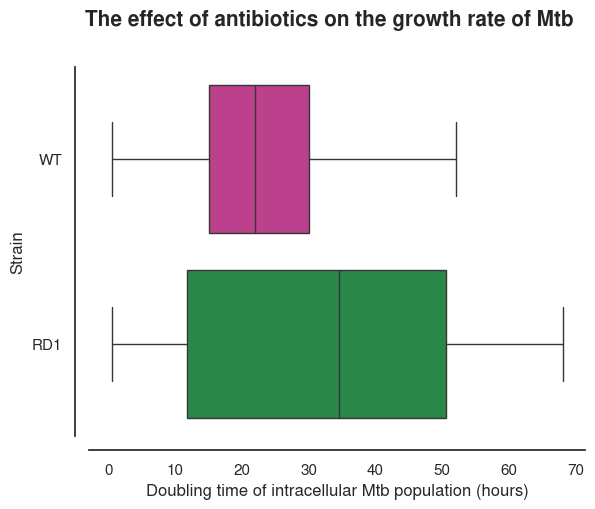

In [124]:
hue_order = ['EC50', 'EC0', 'EC99']
subset_df = df[(df['r2']>=0.59) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                # (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'UNI') & 
                (df['Compound'] == 'CTRL') 
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

g = sns.boxplot(x="Doubling Times", y="Strain",
            # hue="Strain", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=subset_df, 
            hue_order=hue_order, fliersize = 0
            # scale = 'linear'
              )  
sns.despine(offset = 10)
plt.xlabel("Doubling time of intracellular Mtb population (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
# plt.legend(loc = 'lower right', frameon = False, title = 'Concentration')
# plt.xlim(0, 40)
# plt.savefig(os.path.join(output_dir, 'ATB_effect_dt_gt0_violin.png'), bbox_inches='tight', dpi=314)


In [ ]:
#

/tmp/ipykernel_2154516/3625067785.py:22: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=subset_df, x="Doubling Times", hue="Strain",


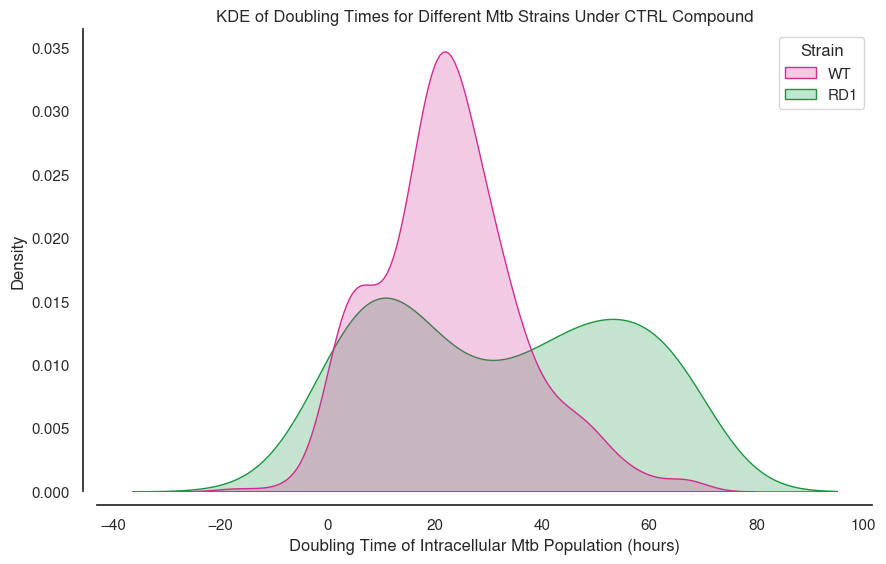

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the subset DataFrame as before
subset_df = df[(df['r2'] >= 0.8) & 
               (df['Edge Status'] == False) &
               (df['Strain'] != 'UNI') & 
               (df['Compound'] == 'CTRL')].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
# subset_df = subset_df[subset_df['Doubling Times'] > 0]

# Plot the KDE for each strain
plt.figure(figsize=(10, 6))
sns.kdeplot(data=subset_df, x="Doubling Times", hue="Strain",
            common_norm=False,  # Ensure each KDE is normalized independently
            fill=True,  # Fill under the KDE curves
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]])

# Add labels and title
plt.xlabel("Doubling Time of Intracellular Mtb Population (hours)")
plt.ylabel("Density")
plt.title('KDE of Doubling Times for Different Mtb Strains Under CTRL Compound')

# Customize the plot
sns.despine(offset=10)
plt.show()


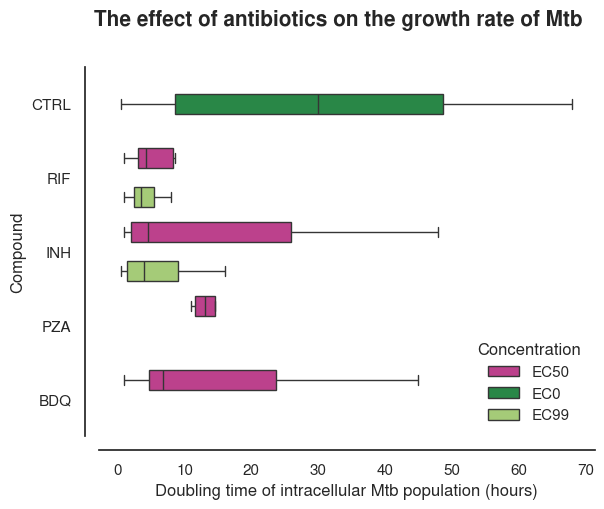

In [186]:
hue_order = ['EC50', 'EC0', 'EC99']
subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                # (df['mtb_origin'].isna()) & 
               (df['Strain'] == 'RD1')
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

g = sns.boxplot(x="Doubling Times", y="Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=subset_df, 
            hue_order=hue_order, fliersize = 0
            # scale = 'linear'
              )  
sns.despine(offset = 10)
plt.xlabel("Doubling time of intracellular Mtb population (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right', frameon = False, title = 'Concentration')
# plt.xlim(0, 40)
# plt.savefig(os.path.join(output_dir, 'ATB_effect_dt_gt

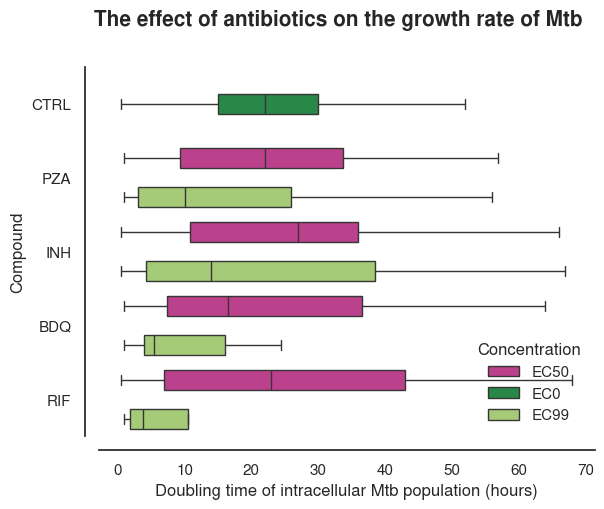

In [135]:
hue_order = ['EC50', 'EC0', 'EC99']
subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                # (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'RD1')
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times')

# Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]
subset_df = subset_df[subset_df['Doubling Times'] > 0]

g = sns.boxplot(x="Doubling Times", y="Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=subset_df, 
            hue_order=hue_order, fliersize = 0
            # scale = 'linear'
              )  
sns.despine(offset = 10)
plt.xlabel("Doubling time of intracellular Mtb population (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right', frameon = False, title = 'Concentration')
# plt.xlim(0, 40)
# plt.savefig(os.path.join(output_dir, 'ATB_effect_dt_gt0_violin.png'), bbox_inches='tight', dpi=314)


In [154]:
filtered_group = group[(group['mtb_origin'] != 'Junk') & ~(group['mtb_origin'].isna())]
filtered_group = filtered_group.explode('Doubling Times')

rapid_growth = filtered_group[filtered_group['Doubling Times'] <= 18]

In [159]:
filtered_group[filtered_group['Doubling Times'] <= 18].groupby('ID').agg({
    'Doubling Times': list,
    # Include other columns as needed, using a suitable aggregation function
    # e.g., 'Strain': 'first' to keep the first non-NaN value per group
    'mtb_origin': 'first',  
    # 'r2': 'first',
    # 'Edge Status': 'first',
    # Add other columns here...
}).reset_index()

,ID,Doubling Times,mtb_origin
0,100.6.7.ND0003,"[2.0, 5.0]",Transfer
1,1054.3.7.ND0003,"[1.5, 4.0]",Transfer
2,108.3.7.PS0000,[4.0],Uptake
3,1098.4.8.ND0003,"[2.5, 5.5]",Uptake
4,11.3.7.PS0000,[2.0],Transfer
...,...,...,...
92,90.3.7.ND0003,[14.5],Uptake
93,90.5.7.PS0000,[13.0],Uptake
94,953.3.7.PS0000,"[3.0, 4.0]",Uptake
95,955.6.8.ND0002,[0.5],Transfer


In [172]:
filtered_group[filtered_group['mtb_origin'] == 'Transfer']

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
152179,135.4.4.PS0000,0.0,0.0,48.786693,232.446354,485.252157,NaN,False,True,7.149152,...,True,True,NaN,NaN,NaN,NaN,Transfer,NaN,NaN,NaN
221311,152.3.4.PS0000,0.0,0.0,69.615459,536.944150,144.393414,NaN,False,True,714.105408,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",1.0,0.88
221311,152.3.4.PS0000,0.0,0.0,69.615459,536.944150,144.393414,NaN,False,True,714.105408,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",1.0,0.88
221311,152.3.4.PS0000,0.0,0.0,69.615459,536.944150,144.393414,NaN,False,True,714.105408,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",1.0,0.88
221311,152.3.4.PS0000,0.0,0.0,69.615459,536.944150,144.393414,NaN,False,True,714.105408,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",3.0,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173378,732.3.4.PS0000,2.0,0.0,35.020040,188.486923,386.069683,NaN,False,True,715.305847,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72]",7.0,0.81
1224314,823.4.4.PS0000,2.0,0.0,3.732193,1308.122531,426.498050,NaN,False,False,987.780823,...,False,False,NaN,NaN,NaN,NaN,Transfer,NaN,NaN,NaN
1253341,88.5.4.PS0000,0.0,0.0,19.577253,343.250031,593.977425,NaN,False,True,89.199280,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36]",3.0,0.95
1253341,88.5.4.PS0000,0.0,0.0,19.577253,343.250031,593.977425,NaN,False,True,89.199280,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36]",17.0,0.95


In [173]:
rapid_growth_counts

Transfer    10
Uptake       8
Unknown      1
Name: mtb_origin, dtype: int64

In [175]:
rapid_growth

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
290540,17.5.12.ND0002,0.0,0.00000,10.302641,818.199545,27.980275,NaN,False,True,795.064697,...,False,False,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68]",0.0,0.87
290540,17.5.12.ND0002,0.0,0.00000,10.302641,818.199545,27.980275,NaN,False,True,795.064697,...,False,False,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68]",1.5,0.87
576601,251.6.12.ND0002,4.0,0.00000,12.492790,5909.827314,-3013.779506,NaN,False,True,389.403625,...,False,False,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68]",0.5,0.48
576601,251.6.12.ND0002,4.0,0.00000,12.492790,5909.827314,-3013.779506,NaN,False,True,389.403625,...,False,False,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68]",0.5,0.48
839060,359.6.12.ND0002,7.5,0.00000,5.028404,3277.826586,-470.993838,NaN,False,True,768.531677,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[2.5, 5.0]",2.0,0.64
992021,496.6.11.ND0002,12.5,0.00000,15.532181,3233.487237,-1113.266290,NaN,False,True,275.596771,...,False,False,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68]",0.0,-0.51
992021,496.6.11.ND0002,12.5,0.00000,15.532181,3233.487237,-1113.266290,NaN,False,True,275.596771,...,False,False,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68]",9.0,-0.51
1027978,535.6.11.ND0003,4.0,0.00000,12.112866,384.214760,1750.063369,NaN,False,True,556.926331,...,False,False,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68, 15.36]",0.5,0.71
1027978,535.6.11.ND0003,4.0,0.00000,12.112866,384.214760,1750.063369,NaN,False,True,556.926331,...,False,False,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68, 15.36]",2.0,0.71
1027978,535.6.11.ND0003,4.0,0.00000,12.112866,384.214760,1750.063369,NaN,False,True,556.926331,...,False,False,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68, 15.36]",7.0,0.71


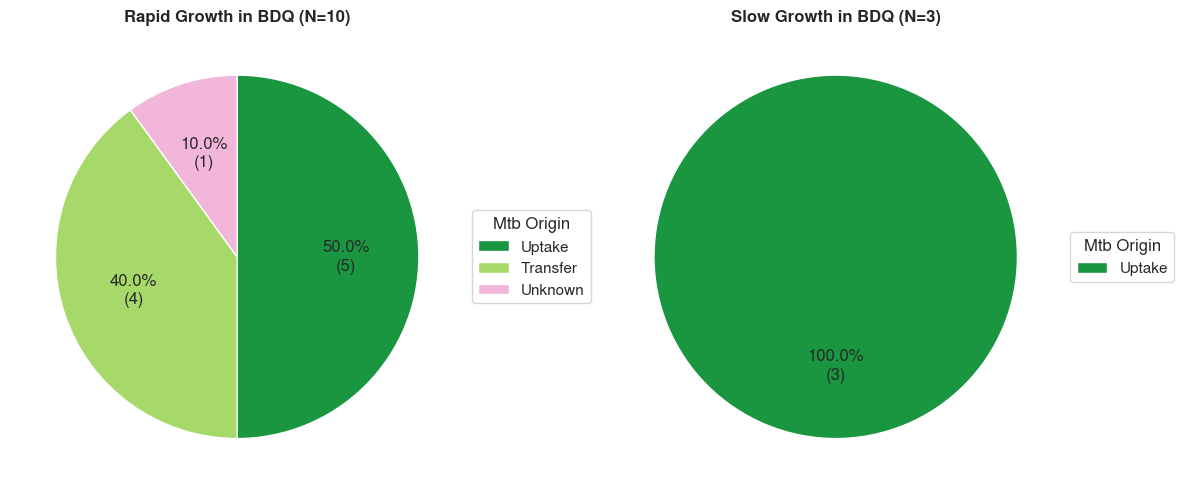

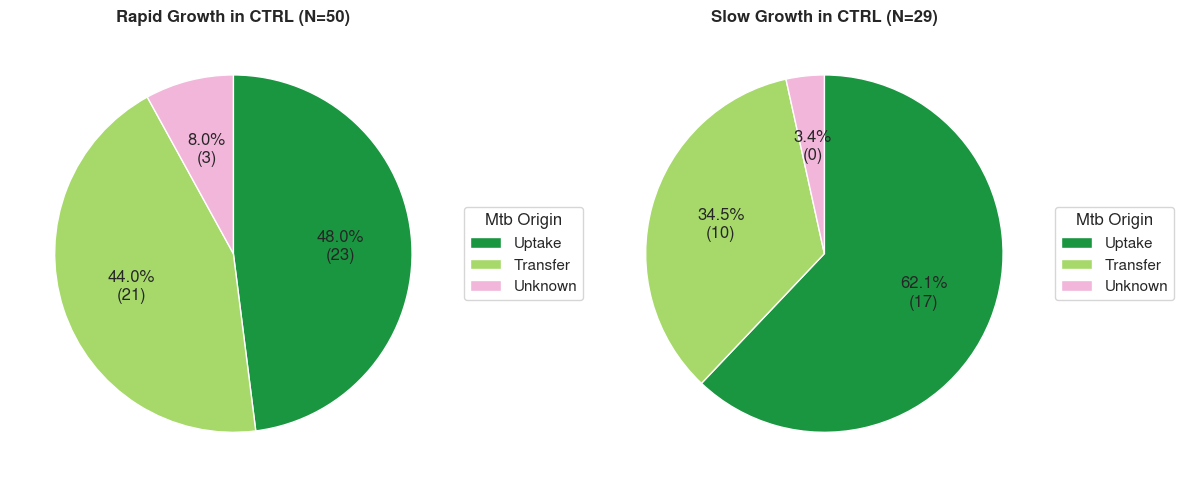

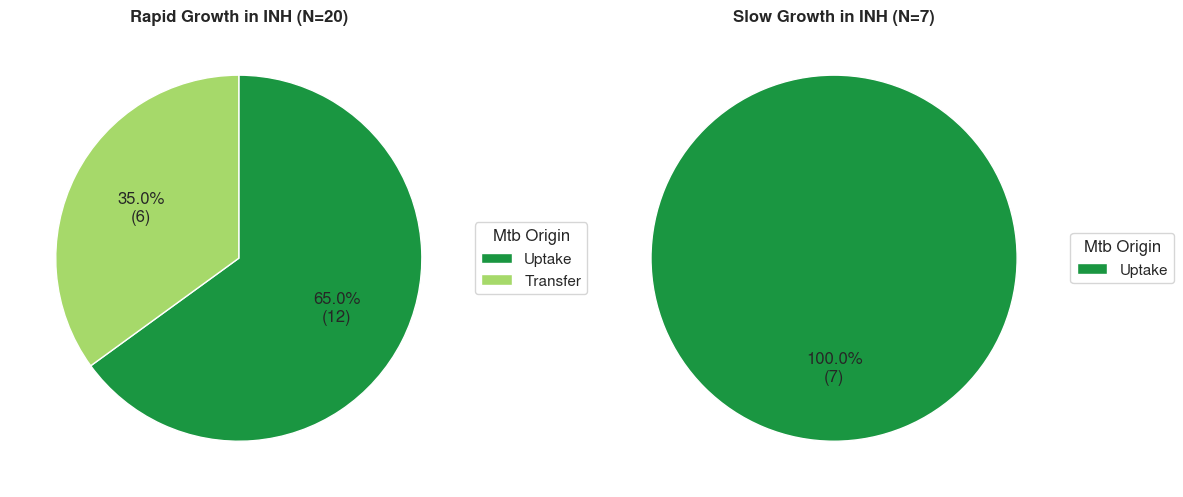

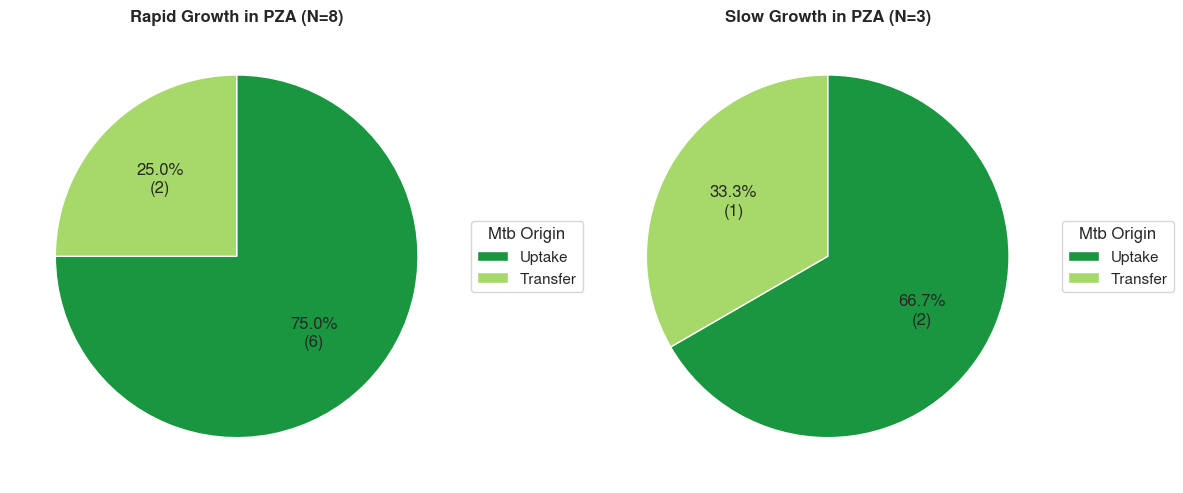

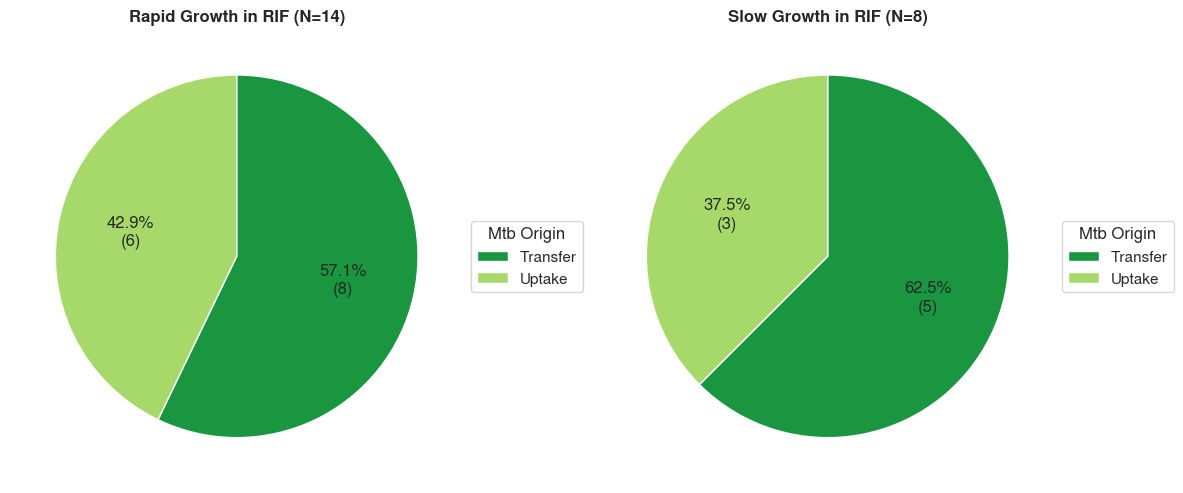

In [177]:
# Function to add counts to pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return f"{pct:.1f}%\n({absolute:d})"

# Colors from expanded_piyg
colors = ['#1a9641', '#a6d96a', '#f1b6da', '#d02c91']

# Group by 'Compound' and 'Concentration'
grouped = df.drop_duplicates('ID').groupby(['Compound'])

# Iterate over each group
for compound, group in grouped:
    # Filter out 'Junk'
    filtered_group = group[(group['mtb_origin'] != 'Junk') & ~(group['mtb_origin'].isna()) & (group['Strain'] == 'RD1')]
    filtered_group = filtered_group.explode('Doubling Times')
    # if compound == 'CTRL':
    #     break
    # Separate into rapid growth and other growth
    rapid_growth = filtered_group[filtered_group['Doubling Times'] <= 18].drop_duplicates('ID')
    other_growth = filtered_group[filtered_group['Doubling Times'] > 18].drop_duplicates('ID')

    # Count the occurrences of each unique value in the 'mtb_origin' column for both groups
    rapid_growth_counts = rapid_growth['mtb_origin'].value_counts()
    other_growth_counts = other_growth['mtb_origin'].value_counts()


    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the rapid growth pie chart
    wedges_rapid, texts_rapid, autotexts_rapid = axes[0].pie(
        rapid_growth_counts,
        autopct=lambda pct: func(pct, rapid_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[0].set_title(f'Rapid Growth in {compound} (N={rapid_growth_counts.sum()})', fontweight='bold')
    axes[0].set_ylabel('')  # Hide the y-label

    # Plot the other growth pie chart
    wedges_other, texts_other, autotexts_other = axes[1].pie(
        other_growth_counts,
        autopct=lambda pct: func(pct, other_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[1].set_title(f'Slow Growth in {compound} (N={other_growth_counts.sum()})', fontweight='bold')
    axes[1].set_ylabel('')  # Hide the y-label

    # Add legends for both subplots
    labels = rapid_growth_counts.index.tolist()
    axes[0].legend(wedges_rapid, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    axes[1].legend(wedges_other, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Adjust layout
    plt.tight_layout()

    # Display the pie charts
    plt.show()

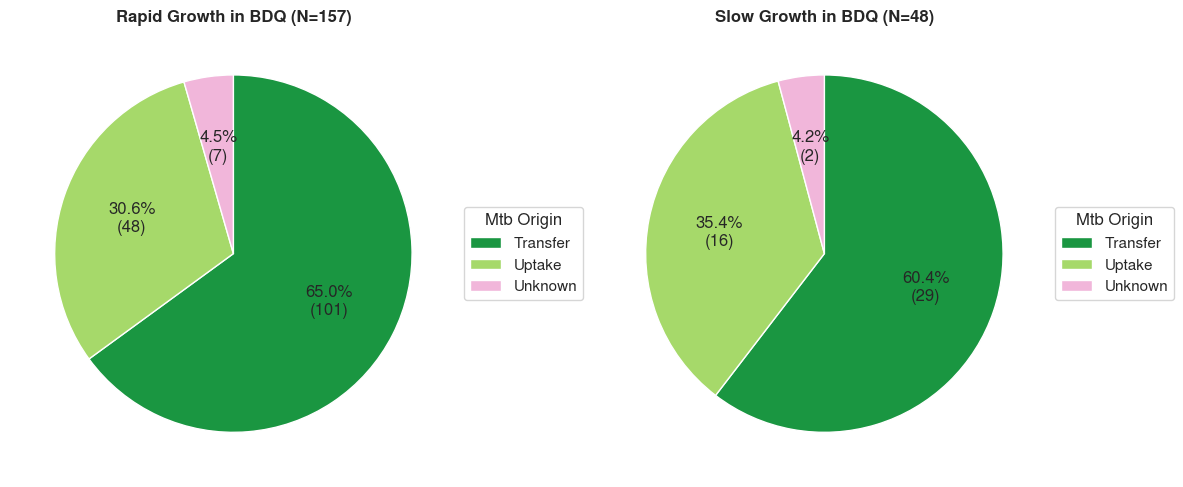

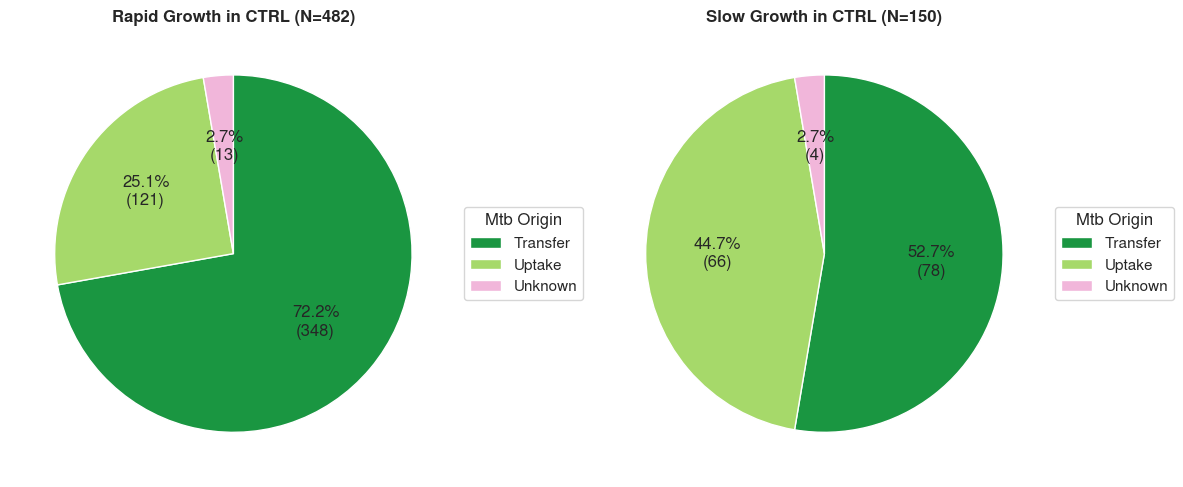

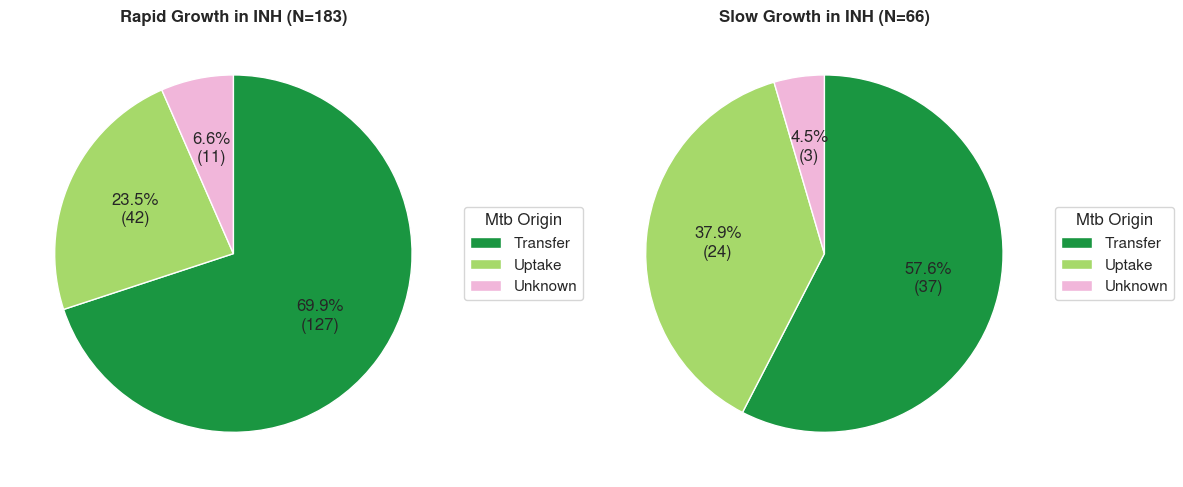

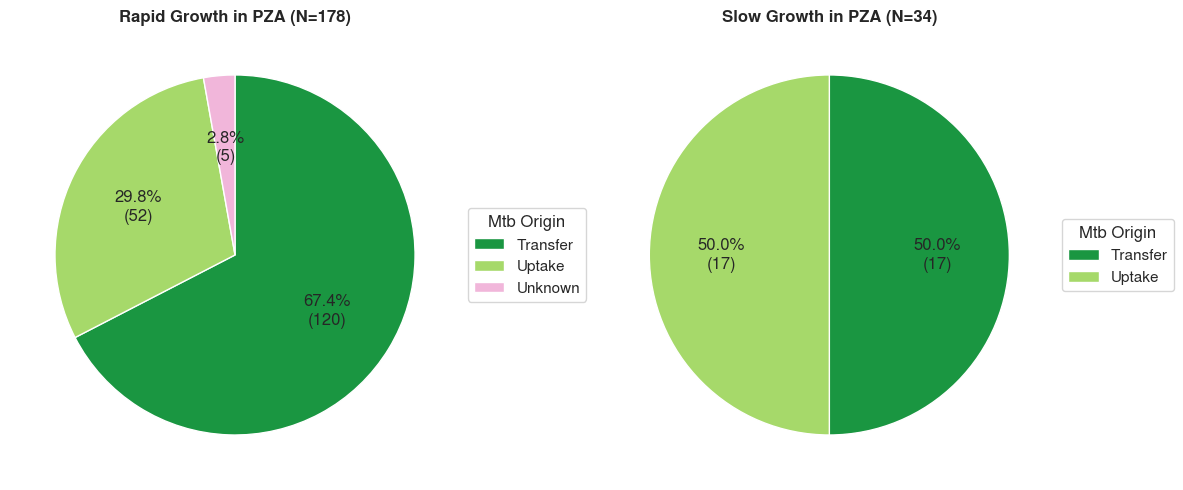

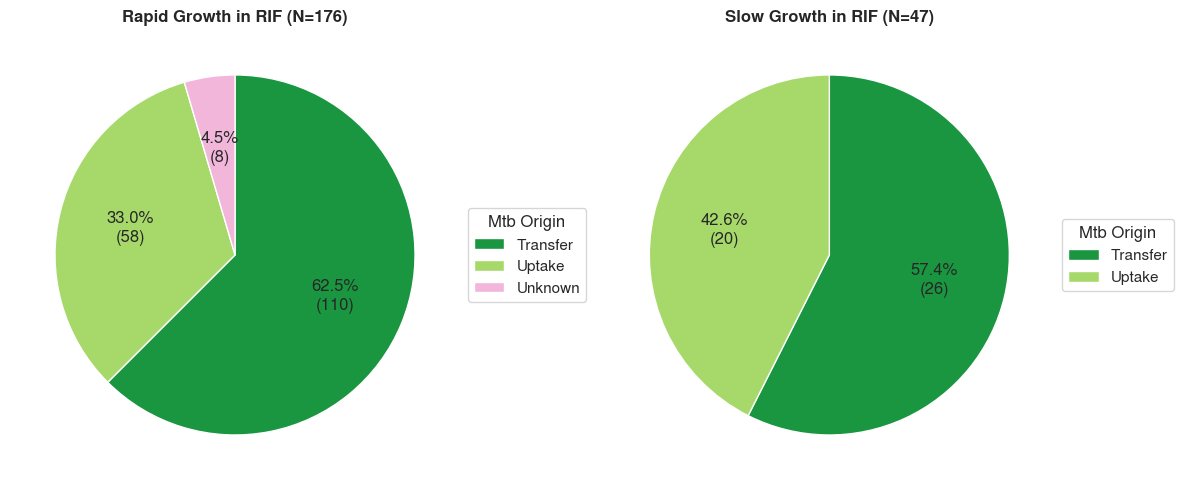

In [178]:
# Function to add counts to pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return f"{pct:.1f}%\n({absolute:d})"

threshold_hr = 15

# Colors from expanded_piyg
colors = ['#1a9641', '#a6d96a', '#f1b6da', '#d02c91']

# Group by 'Compound' and 'Concentration'
grouped = df.drop_duplicates('ID').groupby(['Compound'])

# Iterate over each group
for compound, group in grouped:
    # Filter out 'Junk'
    filtered_group = group[(group['mtb_origin'] != 'Junk') & ~(group['mtb_origin'].isna()) & (group['Strain'] != 'RD1')]
    filtered_group = filtered_group.explode('Doubling Times')

    # Separate into rapid growth and other growth
    rapid_growth = filtered_group[filtered_group['Doubling Times'] <= threshold_hr]
    other_growth = filtered_group[filtered_group['Doubling Times'] > threshold_hr]

    # Count the occurrences of each unique value in the 'mtb_origin' column for both groups
    rapid_growth_counts = rapid_growth['mtb_origin'].value_counts()
    other_growth_counts = other_growth['mtb_origin'].value_counts()


    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the rapid growth pie chart
    wedges_rapid, texts_rapid, autotexts_rapid = axes[0].pie(
        rapid_growth_counts,
        autopct=lambda pct: func(pct, rapid_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[0].set_title(f'Rapid Growth in {compound} (N={rapid_growth_counts.sum()})', fontweight='bold')
    axes[0].set_ylabel('')  # Hide the y-label

    # Plot the other growth pie chart
    wedges_other, texts_other, autotexts_other = axes[1].pie(
        other_growth_counts,
        autopct=lambda pct: func(pct, other_growth_counts),
        startangle=90,
        counterclock=False,
        colors=colors
    )
    axes[1].set_title(f'Slow Growth in {compound} (N={other_growth_counts.sum()})', fontweight='bold')
    axes[1].set_ylabel('')  # Hide the y-label

    # Add legends for both subplots
    labels = rapid_growth_counts.index.tolist()
    axes[0].legend(wedges_rapid, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    axes[1].legend(wedges_other, labels, title="Mtb Origin", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Adjust layout
    plt.tight_layout()

    # Display the pie charts
    plt.show()

In [52]:
subset_df = df[(df['r2']>=0.7) & 
               # (df['r2']<1) & 
               # (df['Doubling Times']>0) & 
               (df['Edge Status']==False) &
                # (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'RD1')
                ].drop_duplicates(subset=['ID'])


In [70]:
subset_df[(subset_df['Compound']=='RIF') & (subset_df['Concentration']=='EC99')]

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
256114,161.5.7.PS0000,0.0,0.893938,36.070418,830.915820,241.676269,NaN,False,True,625.600220,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[2.9, 5.8, 11.6, 23.2]",6.0,0.95
256114,161.5.7.PS0000,0.0,0.893938,36.070418,830.915820,241.676269,NaN,False,True,625.600220,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[2.9, 5.8, 11.6, 23.2]",24.0,0.95
256114,161.5.7.PS0000,0.0,0.893938,36.070418,830.915820,241.676269,NaN,False,True,625.600220,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[2.9, 5.8, 11.6, 23.2]",3.0,0.95
446658,2125.4.8.ND0002,34.5,39.377990,16.157938,3828.850267,392.483691,NaN,True,True,1053.794678,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72]",1.0,0.77
446658,2125.4.8.ND0002,34.5,39.377990,16.157938,3828.850267,392.483691,NaN,True,True,1053.794678,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72]",1.0,0.77
446658,2125.4.8.ND0002,34.5,39.377990,16.157938,3828.850267,392.483691,NaN,True,True,1053.794678,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72]",1.5,0.77
446658,2125.4.8.ND0002,34.5,39.377990,16.157938,3828.850267,392.483691,NaN,True,True,1053.794678,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72]",3.5,0.77
1183548,749.5.7.PS0000,1.0,4.648480,81.527190,823.093859,318.644372,NaN,False,True,782.005249,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",2.0,0.84
1183548,749.5.7.PS0000,1.0,4.648480,81.527190,823.093859,318.644372,NaN,False,True,782.005249,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",26.0,0.84
1183548,749.5.7.PS0000,1.0,4.648480,81.527190,823.093859,318.644372,NaN,False,True,782.005249,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]",5.0,0.84


/tmp/ipykernel_2154516/3187749407.py:22: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  g = sns.boxplot(x="Doubling Times", y="Compound",


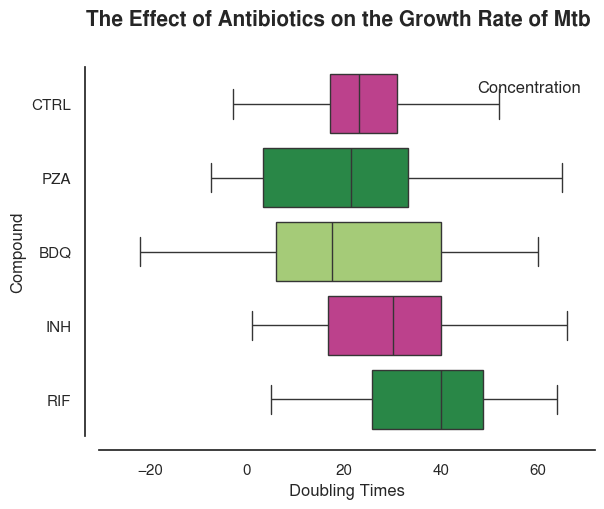

In [127]:
hue_order = ['EC0', 'EC50', 'EC99']
subset_df = df[(df['r2']>=0.90) & 
               # (df['r2']<1) & 
               # (df['dt']>0) & 
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'RD1')
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times').reset_index(drop=True)

# # Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]

# Invert the 'Doubling Times' to represent growth rate (h⁻¹)
subset_df['Growth Rate'] = 1 / subset_df['Doubling Times']

g = sns.boxplot(x="Doubling Times", y="Compound",
                # hue="Concentration", 
                palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
                data=subset_df, 
                hue_order=hue_order, fliersize = 0
            # scale = 'linear'
              )  
# Customize the plot
sns.despine(offset=10)
# plt.xlabel("Growth Rate (h⁻¹)")
plt.gcf().suptitle('The Effect of Antibiotics on the Growth Rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                   y=1.0)
sns.despine(offset=10)
plt.legend(loc='upper right', frameon=False, title='Concentration')
# plt.xlim(0,1)
plt.show()


/tmp/ipykernel_2154516/3032207452.py:22: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  g = sns.boxplot(x="Growth Rate", y="Compound",
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


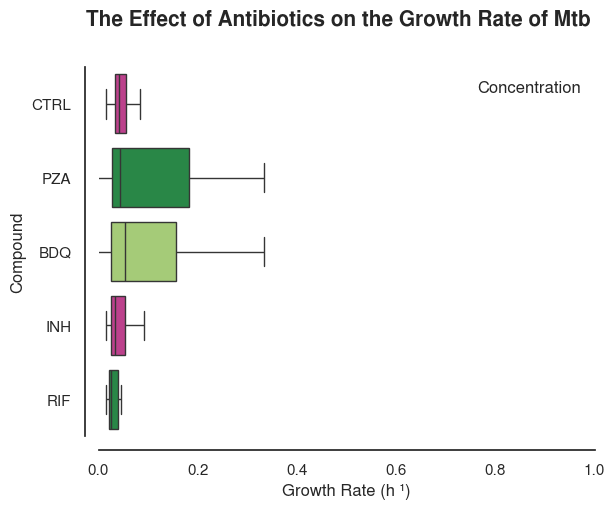

In [125]:
hue_order = ['EC0', 'EC50', 'EC99']
subset_df = df[(df['r2']>=0.90) & 
               # (df['r2']<1) & 
               # (df['dt']>0) & 
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'RD1')
                ].drop_duplicates(subset=['ID'])

# Explode the 'Doubling Times' column so that each value in the list becomes a separate row
subset_df = subset_df.explode('Doubling Times').reset_index(drop=True)

# # Convert 'Doubling Times' to numeric in case there are any non-numeric values
subset_df['Doubling Times'] = pd.to_numeric(subset_df['Doubling Times'], errors='coerce')

# Filter out None or NaN values in 'Doubling Times'
subset_df = subset_df[subset_df['Doubling Times'].notna()]

# Invert the 'Doubling Times' to represent growth rate (h⁻¹)
subset_df['Growth Rate'] = 1 / subset_df['Doubling Times']

g = sns.boxplot(x="Growth Rate", y="Compound",
                # hue="Concentration", 
                palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
                data=subset_df, 
                hue_order=hue_order, fliersize = 0
            # scale = 'linear'
              )  
# Customize the plot
sns.despine(offset=10)
plt.xlabel("Growth Rate (h⁻¹)")
plt.gcf().suptitle('The Effect of Antibiotics on the Growth Rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                   y=1.0)
sns.despine(offset=10)
plt.legend(loc='upper right', frameon=False, title='Concentration')
plt.xlim(0,1)
plt.show()


# Checking lowest doubling times

### Starting at RIF EC99

In [184]:
subset_df =  df[(df['r2']>=0.7) & 
               # (df['Concentration']=='EC99') &
               # (df['Compound']=='RIF') &
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) #& 
               # (df['Strain'] != 'RD1')
                ].drop_duplicates(subset=['ID'])
len(subset_df[subset_df['Doubling Times'].notna()].ID.values)

707

In [238]:
subset_df =  df[(df['r2']>=0.7) & 
               # (df['Concentration']=='EC99') &
               (df['Compound']=='RIF') &
               (df['Edge Status']==False) &
                (df['mtb_origin'].isna()) & 
               (df['Strain'] != 'RD1')
                ].drop_duplicates(subset=['ID'])
subset_df = subset_df[subset_df['Doubling Times'].notna()]
IDs = subset_df.ID.values
IDs

array(['110.3.7.PS0000', '117.4.7.PS0000', '123.3.7.PS0000',
       '125.4.7.PS0000', '132.4.7.PS0000', '1579.3.8.ND0003',
       '158.3.7.PS0000', '1821.3.8.ND0003', '192.3.7.PS0000',
       '195.4.7.PS0000', '2076.3.7.ND0003', '21.4.7.PS0000',
       '24.4.7.PS0000', '2557.3.8.ND0003', '256.3.8.ND0003',
       '268.3.8.ND0003', '271.3.7.PS0000', '323.3.7.PS0000',
       '337.4.7.PS0000', '3376.3.8.ND0003', '3385.3.7.ND0003',
       '36.4.7.PS0000', '371.4.7.PS0000', '378.3.7.PS0000',
       '487.3.7.PS0000', '500.3.7.PS0000', '563.4.7.PS0000',
       '569.4.7.PS0000', '573.3.7.PS0000', '612.3.7.PS0000',
       '658.3.7.PS0000', '673.3.8.ND0003', '717.3.7.PS0000',
       '719.4.7.PS0000', '826.4.7.PS0000', '88.3.7.PS0000',
       '95.3.7.PS0000'], dtype=object)

In [344]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')

In [345]:
df[df['ID']=='268.3.8.ND0003']

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
625887,268.3.8.ND0003,0.0,7.732568,66.866599,1330.359251,-312.453848,NaN,True,True,634.324036,...,False,False,NaN,NaN,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
625888,268.3.8.ND0003,0.5,8.134840,66.866599,1264.520682,-312.453848,NaN,True,True,638.322876,...,False,False,0.402272,NaN,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
625889,268.3.8.ND0003,1.0,7.397341,66.866599,1697.611529,-312.453848,NaN,True,True,639.548279,...,False,False,-0.737499,NaN,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
625890,268.3.8.ND0003,1.5,9.699233,66.866599,1598.362008,-312.453848,NaN,True,True,639.084595,...,False,False,2.301892,NaN,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
625891,268.3.8.ND0003,2.0,8.917036,66.866599,1472.450773,-312.453848,True,True,True,638.781128,...,False,False,-0.782196,NaN,0.0,7.497462,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626036,268.3.8.ND0003,74.5,72.945380,66.866599,1051.472793,-312.453848,NaN,True,True,604.926392,...,False,False,6.995069,69.626634,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
626037,268.3.8.ND0003,75.0,71.537427,66.866599,1003.311857,-312.453848,True,True,True,605.530762,...,False,False,-1.407953,69.358452,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
626038,268.3.8.ND0003,75.5,74.398030,66.866599,1052.411428,-312.453848,True,True,True,604.174255,...,False,False,2.860603,69.358452,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84
626039,268.3.8.ND0003,76.0,76.476437,66.866599,1077.262918,-312.453848,True,True,True,604.518372,...,False,False,2.078407,69.358452,NaN,NaN,None,"[7.9, 15.8, 31.6, 63.2]","[9.5, 5.5, 25.5]",0.84


In [187]:
df[df['ID']=='268.3.8.ND0003']

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
625923,268.3.8.ND0003,18.0,57.122669,66.866599,1322.537289,-312.453848,True,True,True,604.359314,...,False,False,15.107560,11.671484,16.0,26.810268,None,None,None,0.62
625924,268.3.8.ND0003,18.5,34.103753,66.866599,1370.474741,-312.453848,True,True,True,605.053101,...,False,False,-23.018916,19.191742,16.5,28.579265,None,None,None,0.62
625925,268.3.8.ND0003,19.0,35.802236,66.866599,1181.674933,-312.453848,True,True,True,606.003418,...,False,False,1.698483,28.321089,17.0,30.426761,None,None,None,0.62
625926,268.3.8.ND0003,19.5,30.662090,66.866599,1500.229911,-312.453848,True,True,True,605.884583,...,False,False,-5.140146,31.773926,17.5,32.319888,None,None,None,0.62
625927,268.3.8.ND0003,20.0,22.795431,66.866599,1327.900920,-312.453848,True,True,True,599.935242,...,False,False,-7.866659,31.773926,18.0,34.218973,None,None,None,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626036,268.3.8.ND0003,74.5,72.945380,66.866599,1051.472793,-312.453848,NaN,True,True,604.926392,...,False,False,6.995069,69.626634,NaN,NaN,None,None,None,0.62
626037,268.3.8.ND0003,75.0,71.537427,66.866599,1003.311857,-312.453848,True,True,True,605.530762,...,False,False,-1.407953,69.358452,NaN,NaN,None,None,None,0.62
626038,268.3.8.ND0003,75.5,74.398030,66.866599,1052.411428,-312.453848,True,True,True,604.174255,...,False,False,2.860603,69.358452,NaN,NaN,None,None,None,0.62
626039,268.3.8.ND0003,76.0,76.476437,66.866599,1077.262918,-312.453848,True,True,True,604.518372,...,False,False,2.078407,69.358452,NaN,NaN,None,None,None,0.62


In [188]:
df[~df['Doubling Times'].isna()].drop_duplicates('ID')

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
543,1.3.5.PS0000,0.0,46.797680,136.772588,660.776979,-68.386294,NaN,True,True,519.922607,...,False,False,NaN,NaN,NaN,NaN,None,"[50.6, 101.2]",[27.0],0.97
773,1.4.9.PS0000,0.0,1.743180,121.732073,484.671082,377.532570,NaN,False,True,675.107422,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]","[4.0, 1.0, 2.0, 4.0, 24.0]",0.97
1226,1.6.5.PS0000,0.0,0.000000,232.200521,973.700145,969.208104,NaN,False,True,575.485962,...,False,True,NaN,NaN,NaN,NaN,Uptake,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44, 122.88]","[1.0, 0.0, 0.0, 1.0, 0.0, 8.0]",0.7
2218,10.4.6.PS0000,0.0,18.862102,86.466200,810.332887,-447.371514,NaN,True,True,1094.156616,...,False,True,NaN,NaN,NaN,NaN,None,"[20.8, 41.6, 83.2]","[26.0, 30.0]",0.96
2856,100.3.4.PS0000,13.0,10.727262,26.594670,1492.631434,61.726452,True,False,True,648.689331,...,False,False,-0.402272,10.727262,13.0,10.152952,None,[10.2],[47],0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303356,977.3.5.ND0002,10.5,0.000000,128.615399,1818.963678,302.039465,NaN,False,True,799.303162,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44, 122.88...","[1.5, 1.5, 0.5, 1.0, 2.5, 4.5, 16.5]",0.89
1307296,983.4.9.PS0000,4.0,52.250704,99.405959,2453.972879,-987.533843,NaN,True,True,676.657288,...,False,False,NaN,NaN,NaN,NaN,None,"[67.7, 135.4]",[55.0],0.97
1309332,99.4.7.PS0000,0.0,0.000000,73.101819,1382.475830,562.354352,NaN,False,True,87.685143,...,False,True,NaN,NaN,NaN,NaN,Transfer,"[1.92, 3.84, 7.68, 15.36, 30.72, 61.44]","[5.0, 9.0, 1.0, 1.0, 4.0]",0.98
1310604,990.4.8.ND0003,6.5,0.000000,8.380673,358.514029,728.515167,NaN,False,True,654.107849,...,False,False,NaN,NaN,NaN,NaN,Junk,"[1.92, 3.84, 7.68]","[2.5, 14.0]",0.65


In [ ]:
for i, ID in tqdm(enumerate(IDs), total = len(IDs)):
    # if i != 15:
    #     continue
    # Load the video
    glimpse_files = glob.glob(f'/mnt/SYNO/macrohet_syno/glimpses/{ID}.mp4')
    if not glimpse_files:
        print(f"Glimpse file for ID {ID} not found.")
        plt.show()
        continue

    glimpse_fn = glimpse_files[0]

    # Load the video frames using imageio
    video_frames = []
    try:
        reader = imageio.get_reader(glimpse_fn)
        for frame in reader:
            video_frames.append(frame)
        reader.close()
    except Exception as e:
        print(f"Error loading video for ID {ID}: {e}")
        plt.show()
        continue

    # Initialize the Napari viewer
    viewer = napari.Viewer(title=f'ID: {ID} - checking shortest doubling times')

    # Add the video to Napari
    video_frames_array = np.array(video_frames)
    viewer.add_image(video_frames_array, name=f'ID: {ID} Video')

    plot(ID, df, save = False, napari = True)
    viewer.grid.enabled = True
    viewer.dims.current_step = (0, 374, 374)
    
    def mark_transfer(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Transfer'
        print(f"ID {ID} marked as 'Transfer'.")
    
    def mark_uptake(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Uptake'
        print(f"ID {ID} marked as 'Uptake'.")
    
    def mark_junk(viewer):
        df.loc[df['ID'] == ID, 'mtb_origin'] = 'Junk'
        print(f"ID {ID} marked as 'Junk'.")

    def mark_start(viewer):
        # Get the start index from the viewer
        start_index = viewer.dims.current_step[0]
        # Identify rows to drop up to the start index
        drop_indices = df[df['ID'] == ID].index[:start_index]
        # Drop the identified rows
        df.drop(drop_indices, inplace=True)
        print(f"Start index for ID {ID} marked: {start_index}.")
    
    def mark_stop(viewer):
        # Get the stop index from the viewer
        stop_index = viewer.dims.current_step[0]
        # Identify rows to drop after the stop index
        drop_indices = df[df['ID'] == ID].index[stop_index:]
        # Drop the identified rows
        df.drop(drop_indices, inplace=True)
        print(f"Stop index for ID {ID} marked: {stop_index}.")
    
    def regen_dt_and_graph(viewer):
        regen(ID, df)
        plot(ID, df, save=False, napari=True)
    
    def save_df(viewer):
        df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')
        print('DataFrame saved out')

    viewer.bind_key('t', mark_transfer)
    viewer.bind_key('u', mark_uptake)
    viewer.bind_key('j', mark_junk)
    viewer.bind_key('>', mark_start)
    viewer.bind_key('<', mark_stop)
    viewer.bind_key('r', regen_dt_and_graph)
    viewer.bind_key('s', save_df)

    viewer.show(block=True)
    plt.close()
    df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')

In [337]:
def regen(ID, df):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        print(f'No obvious growth for ID {ID}')
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        return
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        print(f'No population doubling for ID {ID}')
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        df.loc[df['ID'] == ID, 'Doubling Times'] = None
        return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # Incorporate N_series and doubling_times into the main DataFrame
    df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
    # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)

    previous_fn = glob.glob(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v3/{ID}_dtmin*.pdf')[0]
    archive_dir = f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v3/arx'
    if previous_fn:
        # Move the file to the archive directory
        shutil.move(previous_fn, os.path.join(archive_dir, os.path.basename(previous_fn)))
        print(f"Moved {previous_fn} to {archive_dir}")
    
    plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v3/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
    plt.close()

In [335]:
os.makedirs(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v3/arx', exist_ok=True)